In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd 'drive/My Drive'
%cd 'Colab Notebooks/LeNet-5'

/content/drive/My Drive
/content/drive/My Drive/Colab Notebooks/LeNet-5


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import torchsummary
from torchsummary import summary
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from model import LeNet5

In [ ]:
model = LeNet5()

/content/drive/My Drive/Colab Notebooks/LeNet-5/model.py:163: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  return(torch.Tensor(kernel_list))


In [ ]:
# check model structure
summary(model,(1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
          Layer_C1-2            [-1, 6, 28, 28]               0
              Tanh-3            [-1, 6, 28, 28]               0
          Layer_S2-4            [-1, 6, 14, 14]              12
              Tanh-5            [-1, 6, 14, 14]               0
          Layer_C3-6           [-1, 16, 10, 10]           1,516
              Tanh-7           [-1, 16, 10, 10]               0
          Layer_S4-8             [-1, 16, 5, 5]              32
              Tanh-9             [-1, 16, 5, 5]               0
           Conv2d-10            [-1, 120, 1, 1]          48,120
         Layer_C5-11            [-1, 120, 1, 1]               0
             Tanh-12            [-1, 120, 1, 1]               0
           Linear-13                   [-1, 84]          10,164
             Tanh-14                   

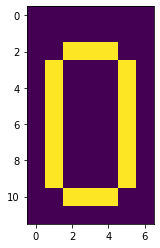

In [ ]:
# kernel example 0
file = './RBF_kernel/0_RBF.jpg'
image = cv2.imread(file, 0)
image = cv2.threshold(image,127,1,cv2.THRESH_BINARY)[1]*-1+1
plt.imshow(image)

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.05,), (0.5,))
    ])

train_data = datasets.MNIST(root='data/', train=True, transform=transform, download=True)
test_data = datasets.MNIST(root='data/', train=False, transform=transform, download=True)

# data loader
train_loader = DataLoader(dataset = train_data, batch_size=256, shuffle=False)
test_loader = DataLoader(dataset = test_data, batch_size=256, shuffle=False)

In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 60000
Number of testing examples: 10000


In [ ]:
def train(model, epoch=200, w_decay=0):
    # optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0)
    
    # loss function
    def loss_fn(output, target):
        loss = output[target==1].pow(2).sum()
        loss += torch.log(np.exp(-0.1)+torch.exp(-output[target==0]).sum())
        return loss

    # training
    train_loss_list=[]
    train_accuracy_list=[]
    for i in range(epoch):
        train_loss = 0
        train_accuracy = 0
        #load data
        for data, target in train_loader:
            data = torch.Tensor(np.pad(data,((0,0),(0,0),(2,2),(2,2)),'constant', constant_values=-0.1))
            target = nn.functional.one_hot(target).float()
            optimizer.zero_grad()

            #forward propagation
            y_pred = model(data)
            loss = loss_fn(y_pred,target)
            
           #backpropagation
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_accuracy += (torch.argmin(model(data),dim=1)==torch.argmax(target,dim=1)).sum().item()


        train_loss /= len(train_loader.dataset)
        train_loss *= 256
        train_loss_list.append(train_loss)

        train_accuracy /= len(train_loader.dataset)
        train_accuracy_list.append(train_accuracy)


        if i%1==0:
            print('epoch : {}/{}, train_loss : {:.8f}, train_acc : {:.4f}'.format(i+1,epoch,train_loss,train_accuracy))
    return(train_loss_list,train_accuracy_list)

In [ ]:
def test(model):
    accuracy = 0
    for data, target in test_loader:
        data = torch.Tensor(np.pad(data,((0,0),(0,0),(2,2),(2,2)),'constant', constant_values=-0.1))
        y_pred = model(data)
        accuracy += (torch.argmin(y_pred,dim=1)==target).sum().item()
    accuracy /= len(test_loader.dataset)
    return(accuracy)

In [ ]:
train_hist_loss, train_hist_acc = train(model,200)

epoch : 1/200, train_loss : 12958.16582083, train_acc : 0.6413
epoch : 2/200, train_loss : 5308.29193437, train_acc : 0.8710
epoch : 3/200, train_loss : 3341.92222917, train_acc : 0.9274
epoch : 4/200, train_loss : 2570.36302578, train_acc : 0.9460
epoch : 5/200, train_loss : 2071.21010026, train_acc : 0.9562
epoch : 6/200, train_loss : 1657.23973685, train_acc : 0.9636
epoch : 7/200, train_loss : 1371.09425716, train_acc : 0.9697
epoch : 8/200, train_loss : 1190.84790104, train_acc : 0.9733
epoch : 9/200, train_loss : 1062.61070605, train_acc : 0.9760
epoch : 10/200, train_loss : 966.72100430, train_acc : 0.9781
epoch : 11/200, train_loss : 890.87555794, train_acc : 0.9795
epoch : 12/200, train_loss : 826.12356361, train_acc : 0.9811
epoch : 13/200, train_loss : 769.32162533, train_acc : 0.9826
epoch : 14/200, train_loss : 719.17930540, train_acc : 0.9835
epoch : 15/200, train_loss : 674.83866257, train_acc : 0.9843
epoch : 16/200, train_loss : 635.51657288, train_acc : 0.9853
epoch :

In [ ]:
torch.save(model,'LeNet_1998.pt')
test(model)

0.991